In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-08-22 11:04:03.518058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:04:03.552458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:04:03.553402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 11:04:05.187717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpmumupi04Streams.root"
file_signal_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpmumupi0200000.root"


In [3]:
mc_mu_signal,mc_mu_only_signal,mc_mu_scf,mc_mu_bkg, mc_mu_signal_weight,mc_mu_only_signal_weight,mc_mu_scf_weight,mc_mu_bkg_weight = process_MC_data_combined(file_signal_mu, file_bkg_mu, 'mu', '521', 'pi0', 'mumu', 0, 'rec521','PIDCorrectionAndAcceptanceWeight')


In [4]:
fit_and_integrate(mc_mu_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


/tmp/ipykernel_3076731/4262147721.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
/tmp/ipykernel_3076731/4262147721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                  value  (rounded)        hesse    at limit
------------------  ------------------  -----------  ----------
extended_0.0437701             80278.9  +/-       0       False
param_fl_0.0437701            0.575262  +/-  0.0076       False
param_s3_0.0437701           -0.013195  +/-   0.008       False
param_p5_0.0437701           -0.364326  +/-   0.021       False
Fit result valid:
True
Signal Events in MC Data = 80278.77855729932
Integrated PDF with trim: 1.0796955481358992
Integrated PDF without trim: 1.1748941075914354
Proportion of data lost: 0.0810


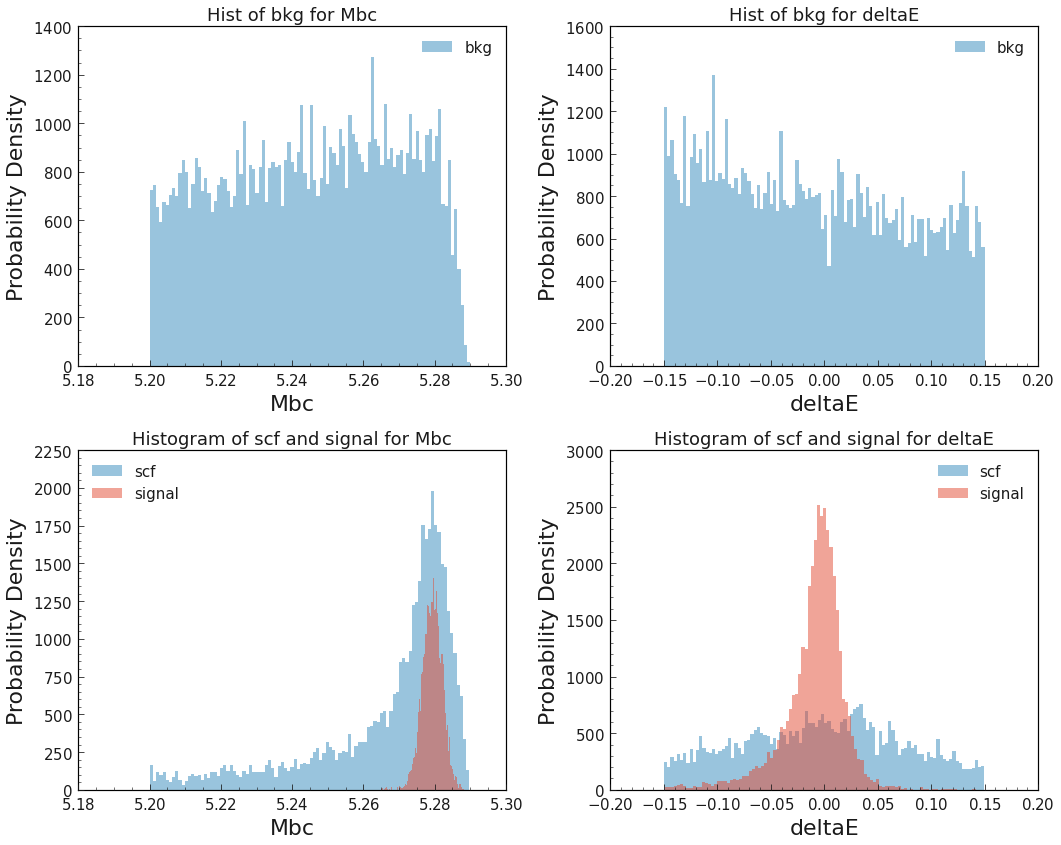

In [4]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_mu_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_mu_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_mu_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_mu_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_mu_scf["Mbc"], 
                           "signal": mc_mu_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_mu_scf_weight, "signal": mc_mu_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_mu_scf["deltaE"], 
                           "signal": mc_mu_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_mu_scf_weight, "signal": mc_mu_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Fit ##

In [8]:
# signal
Mbc_only_signal_cb, result_Mbc_signal = fit('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss, result_deltaE_signal = fit('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)

#scf
Mbc_scf_argus_gauss, result_Mbc_scf = fit('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss, result_deltaE_scf = fit('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)

#bkg
Mbc_bkg_argus_gauss, result_Mbc_bkg = fit('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss, result_deltaE_bkg = fit('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



name                             value  (rounded)    at limit
-----------------------------  ------------------  ----------
mu_mu_Mbc_signal_cb_0.9556                5.27939       False
sigma_mu_Mbc_signal_cb_0.9556          0.00270254       False
alpha_mu_Mbc_signal_cb_0.9556             1.93073       False
n_mu_Mbc_signal_cb_0.9556                 11.6438       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_mu_deltaE_signal_cb_gauss_0.3817            0.890937       False
mu_mu_deltaE_signal_cb_0.3817                 -0.00188421       False
sigma_mu_deltaE_signal_cb_0.3817                0.0146481       False
alpha_mu_deltaE_signal_cb_0.3817                 0.964427       False
n_mu_deltaE_signal_cb_0.3817                      3.29704       False
mu_mu_deltaE_signal_gauss_0.3817               0.00156568       False
sigma_mu_deltaE_signal_gauss_0.3817             0.0381333      

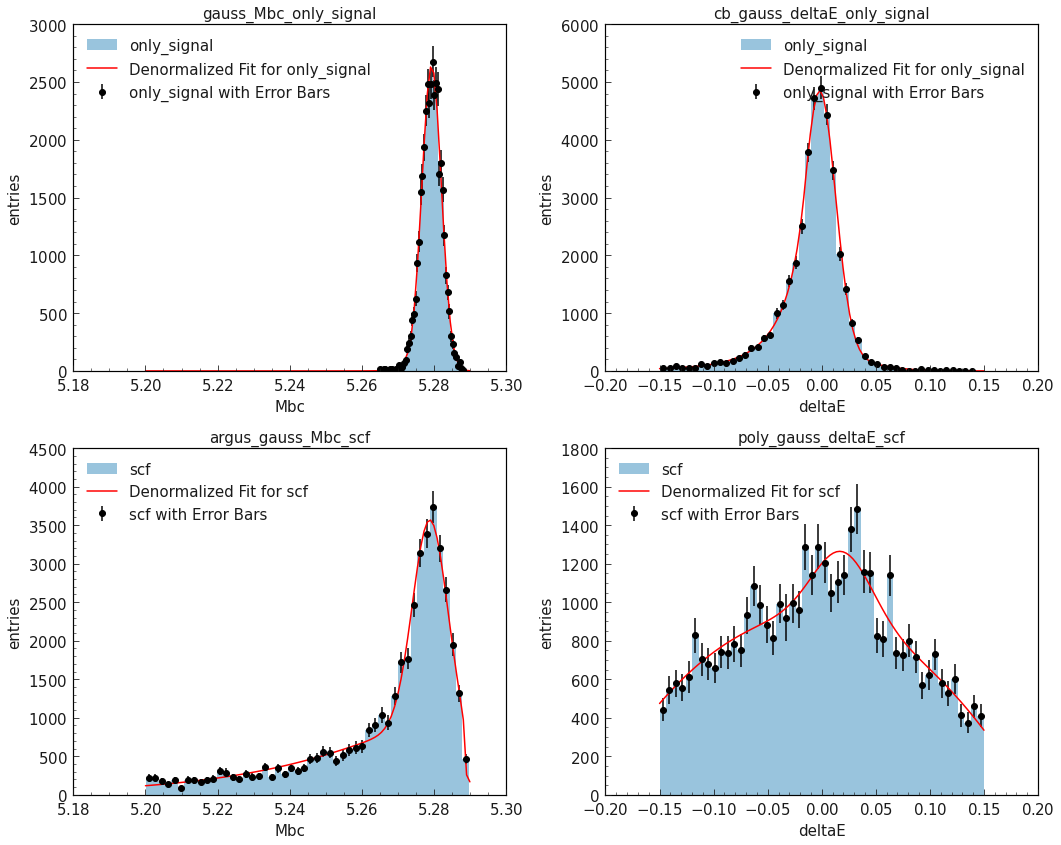

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0,0],50, mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight, 
                                           Mbc_only_signal_cb, Mbc_range, 
                                           'only_signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'gauss_Mbc_only_signal')


fit_model_deltaE_only_signal = plot_with_fit(axs[0,1],50, mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight, 
                                             deltaE_only_signal_cb_gauss, deltaE_range, 
                                             'only_signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

fit_model_Mbc_scf = plot_with_fit(axs[1,0],50, mc_mu_scf["Mbc"], mc_mu_scf_weight, 
                                            Mbc_scf_argus_gauss, Mbc_range, 
                                           'scf', 'Denormalized Fit for scf', 
                                           'Mbc', 'entries', 'argus_gauss_Mbc_scf')


fit_model_deltaE_scf = plot_with_fit(axs[1,1],50, mc_mu_scf["deltaE"], mc_mu_scf_weight, 
                                             deltaE_scf_poly_gauss, deltaE_range, 
                                             'scf', 'Denormalized Fit for scf', 
                                             'deltaE', 'entries', 'poly_gauss_deltaE_scf')




# Adjust layout
plt.tight_layout()


# Print results if needed
print(result_Mbc_signal.params)
print(result_Mbc_signal.valid)
print(result_deltaE_signal.params)
print(result_deltaE_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)

# Show the plots
plt.show()

name                                 value  (rounded)    at limit
---------------------------------  ------------------  ----------
frac_mu_Mbc_bkg_argus_gauss_0.685            0.963863       False
m_mu_Mbc_bkg_argus_0.685                      5.28841       False
c_mu_Mbc_bkg_argus_0.685                     -36.4115       False
p_mu_Mbc_bkg_argus_0.685                     0.456339       False
mu_mu_Mbc_bkg_gauss_0.685                     5.28027       False
sigma_mu_Mbc_bkg_gauss_0.685               0.00448148       False
True
name                                value  (rounded)    at limit
--------------------------------  ------------------  ----------
coeff0_mu_deltaE_bkg_poly_0.3411           -0.242529       False
coeff1_mu_deltaE_bkg_poly_0.3411           0.0436554       False
True


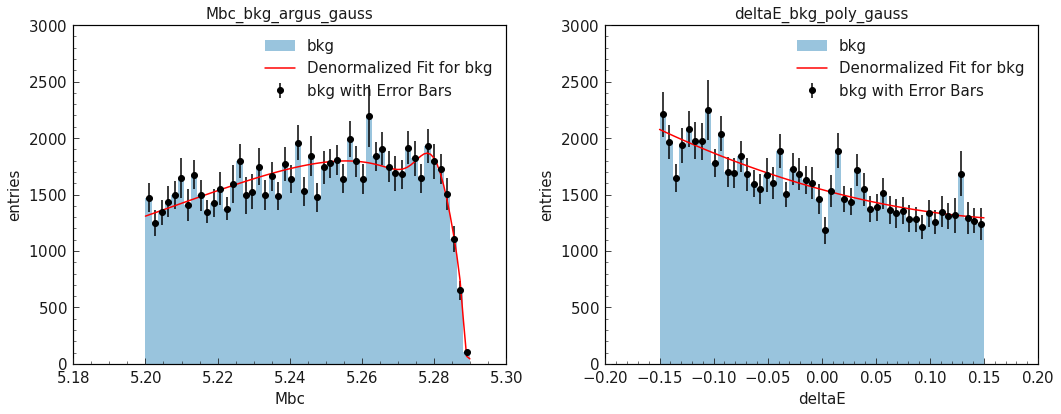

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))  # Changed to 1 row, 2 columns


Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)


fit_model_Mbc_bkg = plot_with_fit(axs[0],50, mc_mu_bkg["Mbc"], mc_mu_bkg_weight, 
                                         Mbc_bkg_argus_gauss, Mbc_range, 
                                         'bkg', 'Denormalized Fit for bkg', 
                                         'Mbc', 'entries', 'Mbc_bkg_argus_gauss')


fit_model_deltaE_bkg = plot_with_fit(axs[1],50, mc_mu_bkg["deltaE"], mc_mu_bkg_weight,
                                             deltaE_bkg_poly_gauss, deltaE_range, 
                                             'bkg', 'Denormalized Fit for bkg', 
                                             'deltaE', 'entries', 'deltaE_bkg_poly_gauss')



# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_bkg.params)
print(result_Mbc_bkg.valid)
print(result_deltaE_bkg.params)
print(result_deltaE_bkg.valid)


# Show the plots
plt.show()

## Yield

In [9]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed_unfixed_data('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed_unfixed_data('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



In [10]:
Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"],mc_mu_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"],mc_mu_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight,mc_mu_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),1,1,10000,10000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                                     value  (rounded)               errors    at limit
-------------------------------------  ------------------  -------------------  ----------
signal_yield_0.5657                                 49255  -2.9e+02   +2.9e+02       False
background_yield_0.5657                            110579  -3.8e+02   +3.8e+02       False
mu_mu_Mbc_signal_cb_0.2323                        5.27938  -1.6e-05   +1.7e-05       False
frac_mu_deltaE_signal_cb_gauss_0.7494            0.665337  -  0.007   + 0.0071       False
frac_Mbc_bkg1_0.5657                             0.349064  - 0.0088   + 0.0092       False
frac_mu_Mbc_scf_argus_gauss_0.591                0.892443  -  0.022   +  0.022       False
frac_mu_Mbc_bkg_argus_gauss_0.4826                0.97709  - 0.0099   +   0.01       False
frac_deltaE_bkg1_0.5657                           0.11922  -  0.017   +  0.017       False
frac_mu_deltaE_scf_poly_gauss_0.7754              1.01975  -  0.026   +  0.022       False

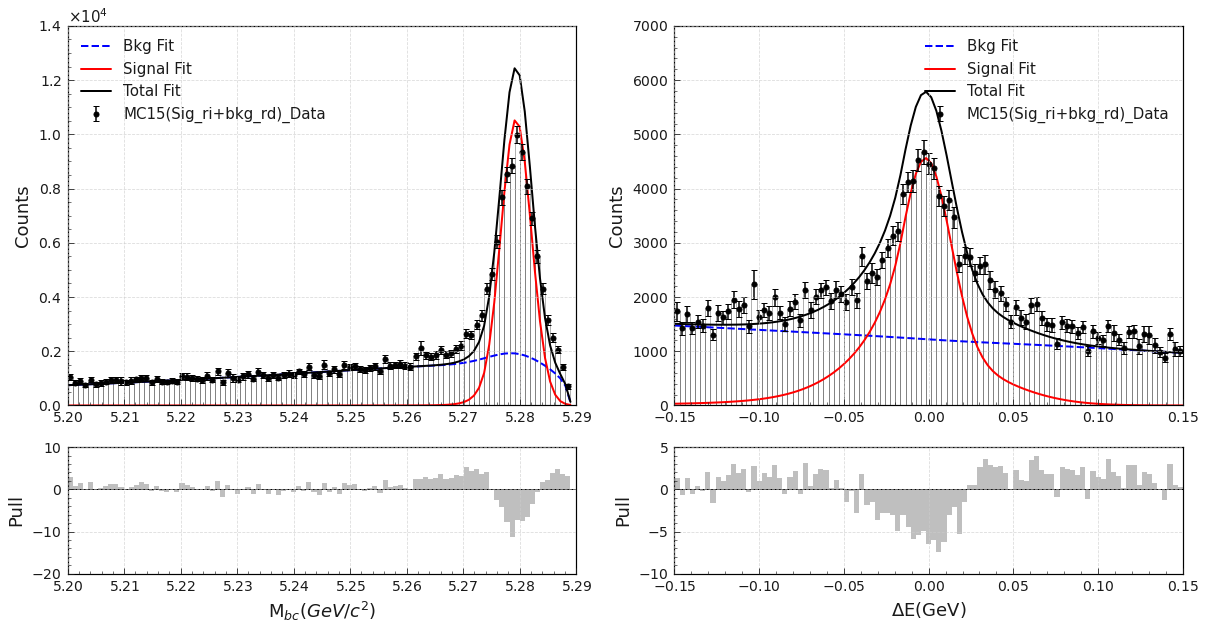

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('Bppi0_q2reg0_decay_mumu.pdf')
plt.show()
   
